In [80]:
%matplotlib inline

import os

import matplotlib
import numpy as np
import pylab as pl
import pandas as pd
from scipy import optimize
import matplotlib.pyplot as plt
from astropy.time import Time
from astropy.table import Table
import seaborn as sns

import corner

import radvel
import radvel.likelihood
from radvel.plot import orbit_plots, mcmc_plots
import random 
from matplotlib import ticker
from astropy.timeseries import LombScargle

matplotlib.rcParams['font.size'] = 9
plt.rcParams['font.family'] = 'stixgeneral'
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.size'] = 11
plt.rcParams['figure.facecolor'] = 'white'
#plt.rcParams['legend.handletextpad']=-0.5

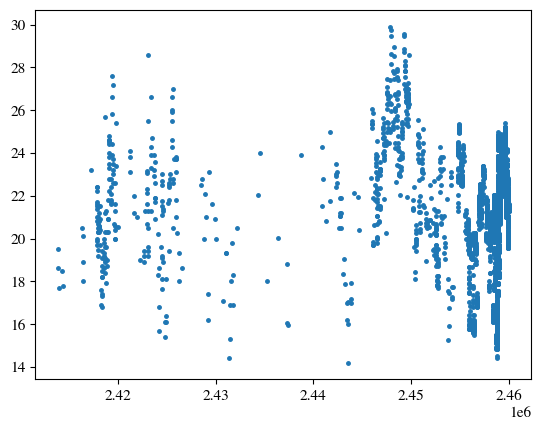

['JD', 'Magnitude', 'Uncertainty', 'HQuncertainty', 'Band', 'Observer Code', 'Comment Code(s)', 'Comp Star 1', 'Comp Star 2', 'Charts', 'Comments', 'Transfomed', 'Airmass', 'Validation Flag', 'Cmag', 'Kmag', 'HJD', 'Star Name', 'Observer Affiliation', 'Measurement Method', 'Grouping Method', 'ADS Reference', 'Digitizer', 'Credit']
chi2/dof =  0.8914220626314039


Text(0, 0.5, 'mag, flattened')

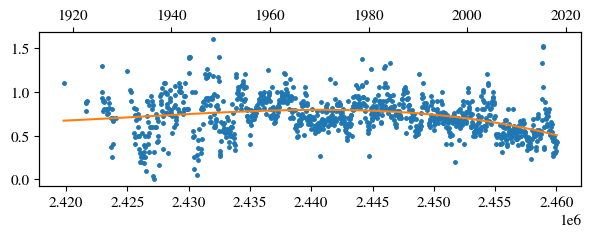

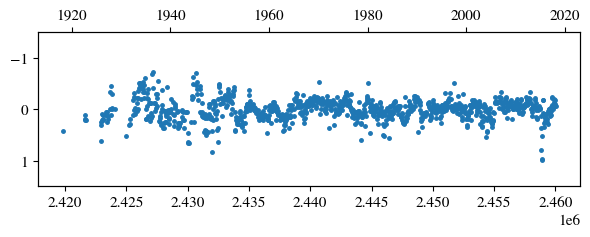

In [2]:
## RVs
rva = Table.read('RVs/BG_rvall.csv')
plt.plot(rva['JD'],rva['RV'],'.')
plt.show()

# Photometry
daavso = Table.read("aavsodata_643217704ea90.txt",format='ascii') # new AAVSO file
# removed a few measurements that had photometry given as <1.6 
daavso.sort('JD')
print(daavso.keys())
daavso['Magnitude']=daavso['Magnitude'].astype(float)

selVisV = (daavso['Band']=='Vis.') | (daavso['Band']=='V') 
selVis  = (daavso['Band']=='Vis.')
selV  = (daavso['Band']=='V')
selJ  = (daavso['Band']=='J')
selH  = (daavso['Band']=='H')
seldate = daavso['JD']<2458000



from astropy.modeling import models, fitting


def get_rolling_means(t,rv,dt):
    """time (JD), rv (km/s), dt (days)"""

    bins = np.linspace(t[0],t[-1],int(np.ceil((t[-1]-t[0])/dt)) )
    xpm = (bins[1:]+bins[:-1])/2
    ypm = np.zeros_like(xpm)
    epm = np.zeros_like(xpm)

    for i in range(len(bins)-1):
        sel = (t >= bins[i]) & (t < bins[i+1])
        #print(bins[i],bins[i+1],len(rv[sel]), np.nanmean(rv[sel]), np.sqrt( np.var(rv[sel]) ) )
        ypm[i] = np.nanmean(rv[sel])
        epm[i] = np.sqrt( np.var(rv[sel]) )

    sel = np.isfinite(ypm)
    return xpm[sel],ypm[sel],epm[sel]

# 12 = 1 month rolling means
npyr =12
#seldate2 = (daavso['JD']>Time(1950,format='jyear').jd ) & (daavso['JD']<Time(1990,format='jyear').jd )
mysel = selVis  #& seldate #selVis & seldate
_t,_mag,_emag = get_rolling_means(daavso[mysel]['JD'],daavso[mysel]['Magnitude'],365.25/npyr)
aavsoT = Table([_t,_mag,_emag],names=['JD','mag','mag_err'])


fig,ax = plt.subplots(figsize=(7,2))
ax.plot(aavsoT['JD'],aavsoT['mag'],'.')

ayr = ax.twiny()
ayr.set_xlim(Time(aavsoT['JD'][0],format='jd').jyear, Time(aavsoT['JD'][-1],format='jd').jyear)



m_init = models.Polynomial1D(3)
fit_m = fitting.LevMarLSQFitter()
m = fit_m(m_init, aavsoT['JD'],aavsoT['mag'] )

ax.plot(aavsoT['JD'],m(aavsoT['JD']) )

print('chi2/dof = ',np.sum(  (aavsoT['mag']-m(aavsoT['JD']))**2 )  / np.std(aavsoT['mag'])**2  / (len(aavsoT)-len(m_init.parameters)))\


aavsoT['mag_flat'] = aavsoT['mag']-m(aavsoT['JD'])

fig,ax = plt.subplots(figsize=(7,2))
ax.plot(aavsoT['JD'],aavsoT['mag_flat'],'.')
ax.set_ylim(1.5,-1.5)

ayr = ax.twiny()
ayr.set_xlim(Time(aavsoT['JD'][0],format='jd').jyear, Time(aavsoT['JD'][-1],format='jd').jyear)
plt.ylabel('mag, flattened')

# Summary Figure

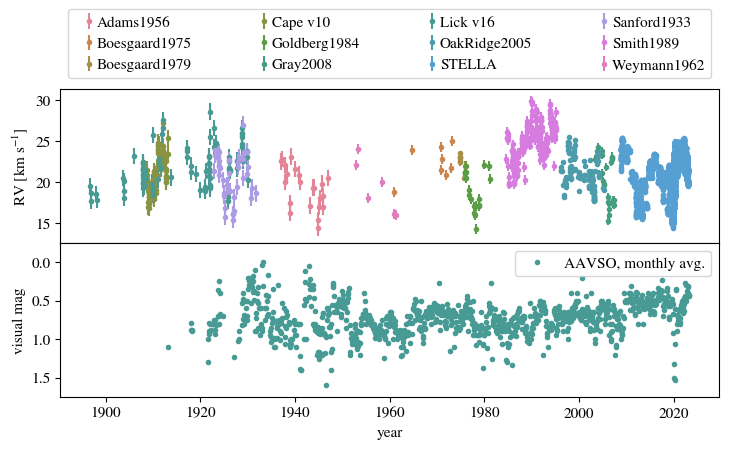

In [3]:
fig,axs = plt.subplots(figsize=(8.5,4),nrows=2,ncols=1,sharex=True)

colors=sns.color_palette("husl",n_colors=len(np.unique(rva['source'])),desat=0.7 )
for i,source in enumerate(np.unique(rva['source'])):
    sel = rva['source']==source
    axs[0].errorbar(Time(rva['JD'][sel],format='jd').jyear,rva['RV'][sel],rva['RV_err'][sel],
                 label=source,marker='o',linestyle='',color=colors[i],markersize=3,rasterized=True)
axs[0].legend(bbox_to_anchor=(0, 1.02,1,0.2),loc='lower left',mode='expand',ncols=4,handletextpad=-0.5)
axs[0].set_ylabel('RV [km s$^{-1}$]')

axs[1].plot(Time(aavsoT['JD'],format='jd').jyear,aavsoT['mag'],
                marker='o',linestyle='',markersize=3,label='AAVSO, monthly avg.',color=colors[6],rasterized=True)
axs[1].legend(loc='upper right')
axs[1].set_ylim(1.75,-0.25)
axs[1].set_ylabel('visual mag')
axs[1].set_xlabel('year')

plt.subplots_adjust(hspace=0)

plt.savefig("figs/rv_aavso_summary.pdf",bbox_inches='tight',dpi=300)

# Periodogram

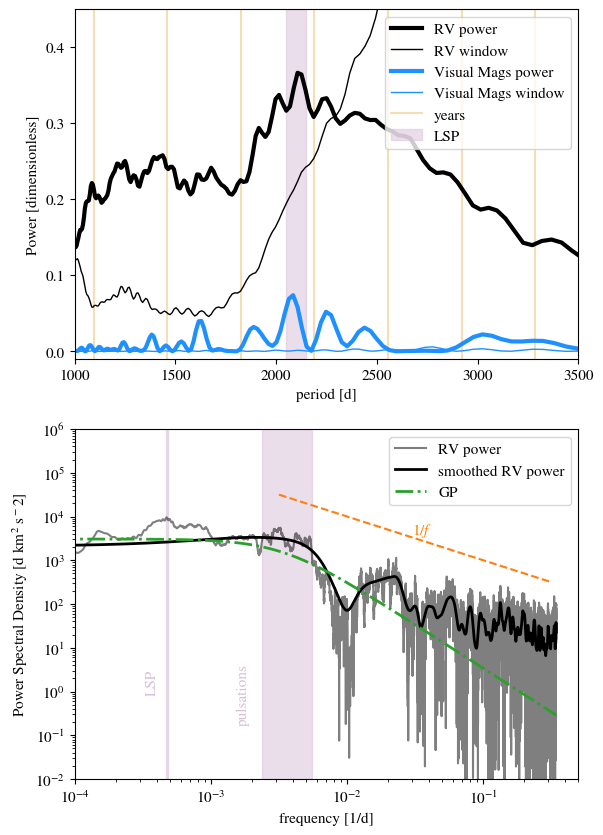

In [29]:



window_fr, window = LombScargle(rva['JD'], np.ones_like(rva['RV'])).autopower()
fr, power = LombScargle(rva['JD'], rva['RV']).autopower()
a_fr, a_pow = LombScargle(aavsoT['JD'],aavsoT['mag']).autopower()
a_wfr,a_wpow = LombScargle(aavsoT['JD'],np.ones_like(aavsoT['mag'])).autopower()


plt.figure(figsize=(6.5,10))
plt.subplot(211)
plt.plot(1/fr,power,label='RV power',ls='-',lw=3,color='k')
plt.plot(1/window_fr,window,label='RV window',lw=1,color='k')
plt.plot(1/a_fr,a_pow,label='Visual Mags power',ls='-',lw=3,color='dodgerblue')
plt.plot(1/a_wfr,a_wpow,label='Visual Mags window',ls='-',lw=1,color='dodgerblue')


for i in range(10):
    plt.axvline(i*365,color='wheat',label=np.where(i==0,'years',''),zorder=0)

#plt.axvline(2110,color='Cyan',ls="--",label='2110 d',zorder=0)
plt.axvspan(2050,2150,alpha=0.5,color='thistle',label='LSP')


#plt.semilogx()
plt.xlim(1000,3500)
plt.ylim(-0.01,0.45)
plt.legend(loc='upper right')
plt.xlabel('period [d]')
plt.ylabel('Power [dimensionless]')




from astropy.convolution import Gaussian1DKernel, convolve

plt.subplot(212)

def Sexp(f,l=3000):
    """ f is in [1/d], ref: p28: https://gpss.cc/gpss21/slides/Heinonen2021.pdf,
     Wolfram Alpha: "Fourier transform exp(- |x|/l)" (normalization 1)  """ 
    return 2*l/(1+(l*f)**2)  #((1/l + l*f**2  ))**-1


rv = Table.read("RVs/BG_rvall.csv")
fr, power = LombScargle(rv["JD"], rv['RV'],normalization='psd').autopower(method='auto')



plt.loglog(fr,power,label='RV power',ls='-',alpha=0.5,color='k')
plt.loglog(fr,convolve(power,Gaussian1DKernel(300)),label='smoothed RV power',ls='-',lw=2,color='k')
plt.xlabel('frequency [1/d]')
plt.ylabel('Power Spectral Density [d km$^2$ s$^-2$]')

xp = np.logspace(-2.5,-0.5,100)
plt.plot(xp,1e2/xp,ls='--',color='C1')

plt.axvspan(1/2150,1/2050,alpha=0.5,color='thistle')
plt.axvspan(1/420,1/180,alpha=0.5,color='thistle')
plt.annotate("LSP",(1/3000,1),rotation=90,color='thistle')
plt.annotate("pulsations",(1/650,0.2),rotation=90,color='thistle')
plt.annotate("$1/f$",(0.03,4e3),color='C1')

plt.plot(fr,2.26**2 * Sexp(fr,l=300),ls='-.',label='GP',lw=2,color='C2')

plt.xlim(1e-4,0.5)
plt.ylim(1e-2,1e6)
plt.legend(loc="upper right")


plt.savefig("figs/power_spec.pdf",bbox_inches='tight',dpi=300)

# RADVEL ANALYSIS

240000
757 data points


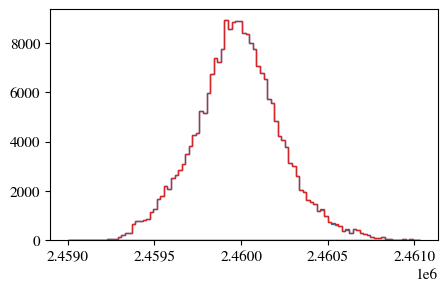

2023.0970302983064
per1 : 2112.9 +/- 9.8
tc1 : 2459979 +/- 240
secosw1 : 0.08 +/- 0.29
sesinw1 : -0.39 +/- 0.37
logk1 : 7.23 +/- 0.28
gamma : 21139 +/- 300
jit : 19 +/- 11
gp_length : 300.02 +/- 0.98
gp_amp : 2260 +/- 21


In [31]:
gppost = radvel.posterior.load("radvel/BG_radvel_MLE_Exp300.0_rv10_p2000.0_2200.0_e0.6___iter_0.pkl")
gpchains = gppost.chains
gplike = gppost.likelihood
print( len(gpchains) )

vfactor=1e3


print(gplike.N,"data points")


# FOLD TC1
tc1med = gpchains['tc1'].quantile(0.5)
sel_p1 = np.abs(gpchains['tc1'] - tc1med) > np.abs(gpchains['tc1'] - gpchains['per1'] - tc1med)
sel_m1 = np.abs(gpchains['tc1'] - tc1med) > np.abs(gpchains['tc1'] + gpchains['per1'] - tc1med)


gpchains.loc[:,'tc1_fold'] = gpchains['tc1'].loc[:]
gpchains.loc[sel_p1,'tc1_fold'] = gpchains['tc1'].loc[sel_p1]-gpchains['per1'].loc[sel_p1]
gpchains.loc[sel_m1,'tc1_fold'] = gpchains['tc1'].loc[sel_m1]+gpchains['per1'].loc[sel_m1]


plt.figure(figsize=(5,3))
mybins = np.linspace(2459000,2459032.625+2000, 100)
plt.hist(gpchains['tc1'],histtype='step',bins=mybins,density=False)

plt.hist(gpchains['tc1'][sel_p1],histtype='step',bins=mybins,density=False)
plt.hist(gpchains['tc1'][sel_m1],histtype='step',bins=mybins,density=False)

plt.hist(gpchains['tc1_fold'],histtype='step',bins=mybins,density=False)

plt.show()

# write over tc1
gpchains.tc1.loc[:] = gpchains.tc1_fold.loc[:]
# drop column
gpchains.drop(['tc1_fold'],axis=1)
 
print(np.mean(Time(gpchains['tc1'],format='jd').jyear) )






quants = gpchains.quantile([0.159, 0.5, 0.841]) # median & 1sigma limits of posterior distributions

for par in gppost.params.keys():
    if gppost.params[par].vary:
        med = quants[par][0.5]
        high = quants[par][0.841] - med
        low = med - quants[par][0.159]
        err = np.mean([high,low])
        err = radvel.utils.round_sig(err)
        med, err, errhigh = radvel.utils.sigfig(med, err)
        print('{} : {} +/- {}'.format(par, med, err))
        
        
#df_synth = gppost.params.basis.to_synth(gpchains)
labels = 'per1 tc1 logk1 gamma'.split()
#gpchains[labels].quantile([0.01,0.05,0.14,0.5,0.84,0.95,0.99]).T

Corner plot saved to figs/corner_mcmc_full.pdf


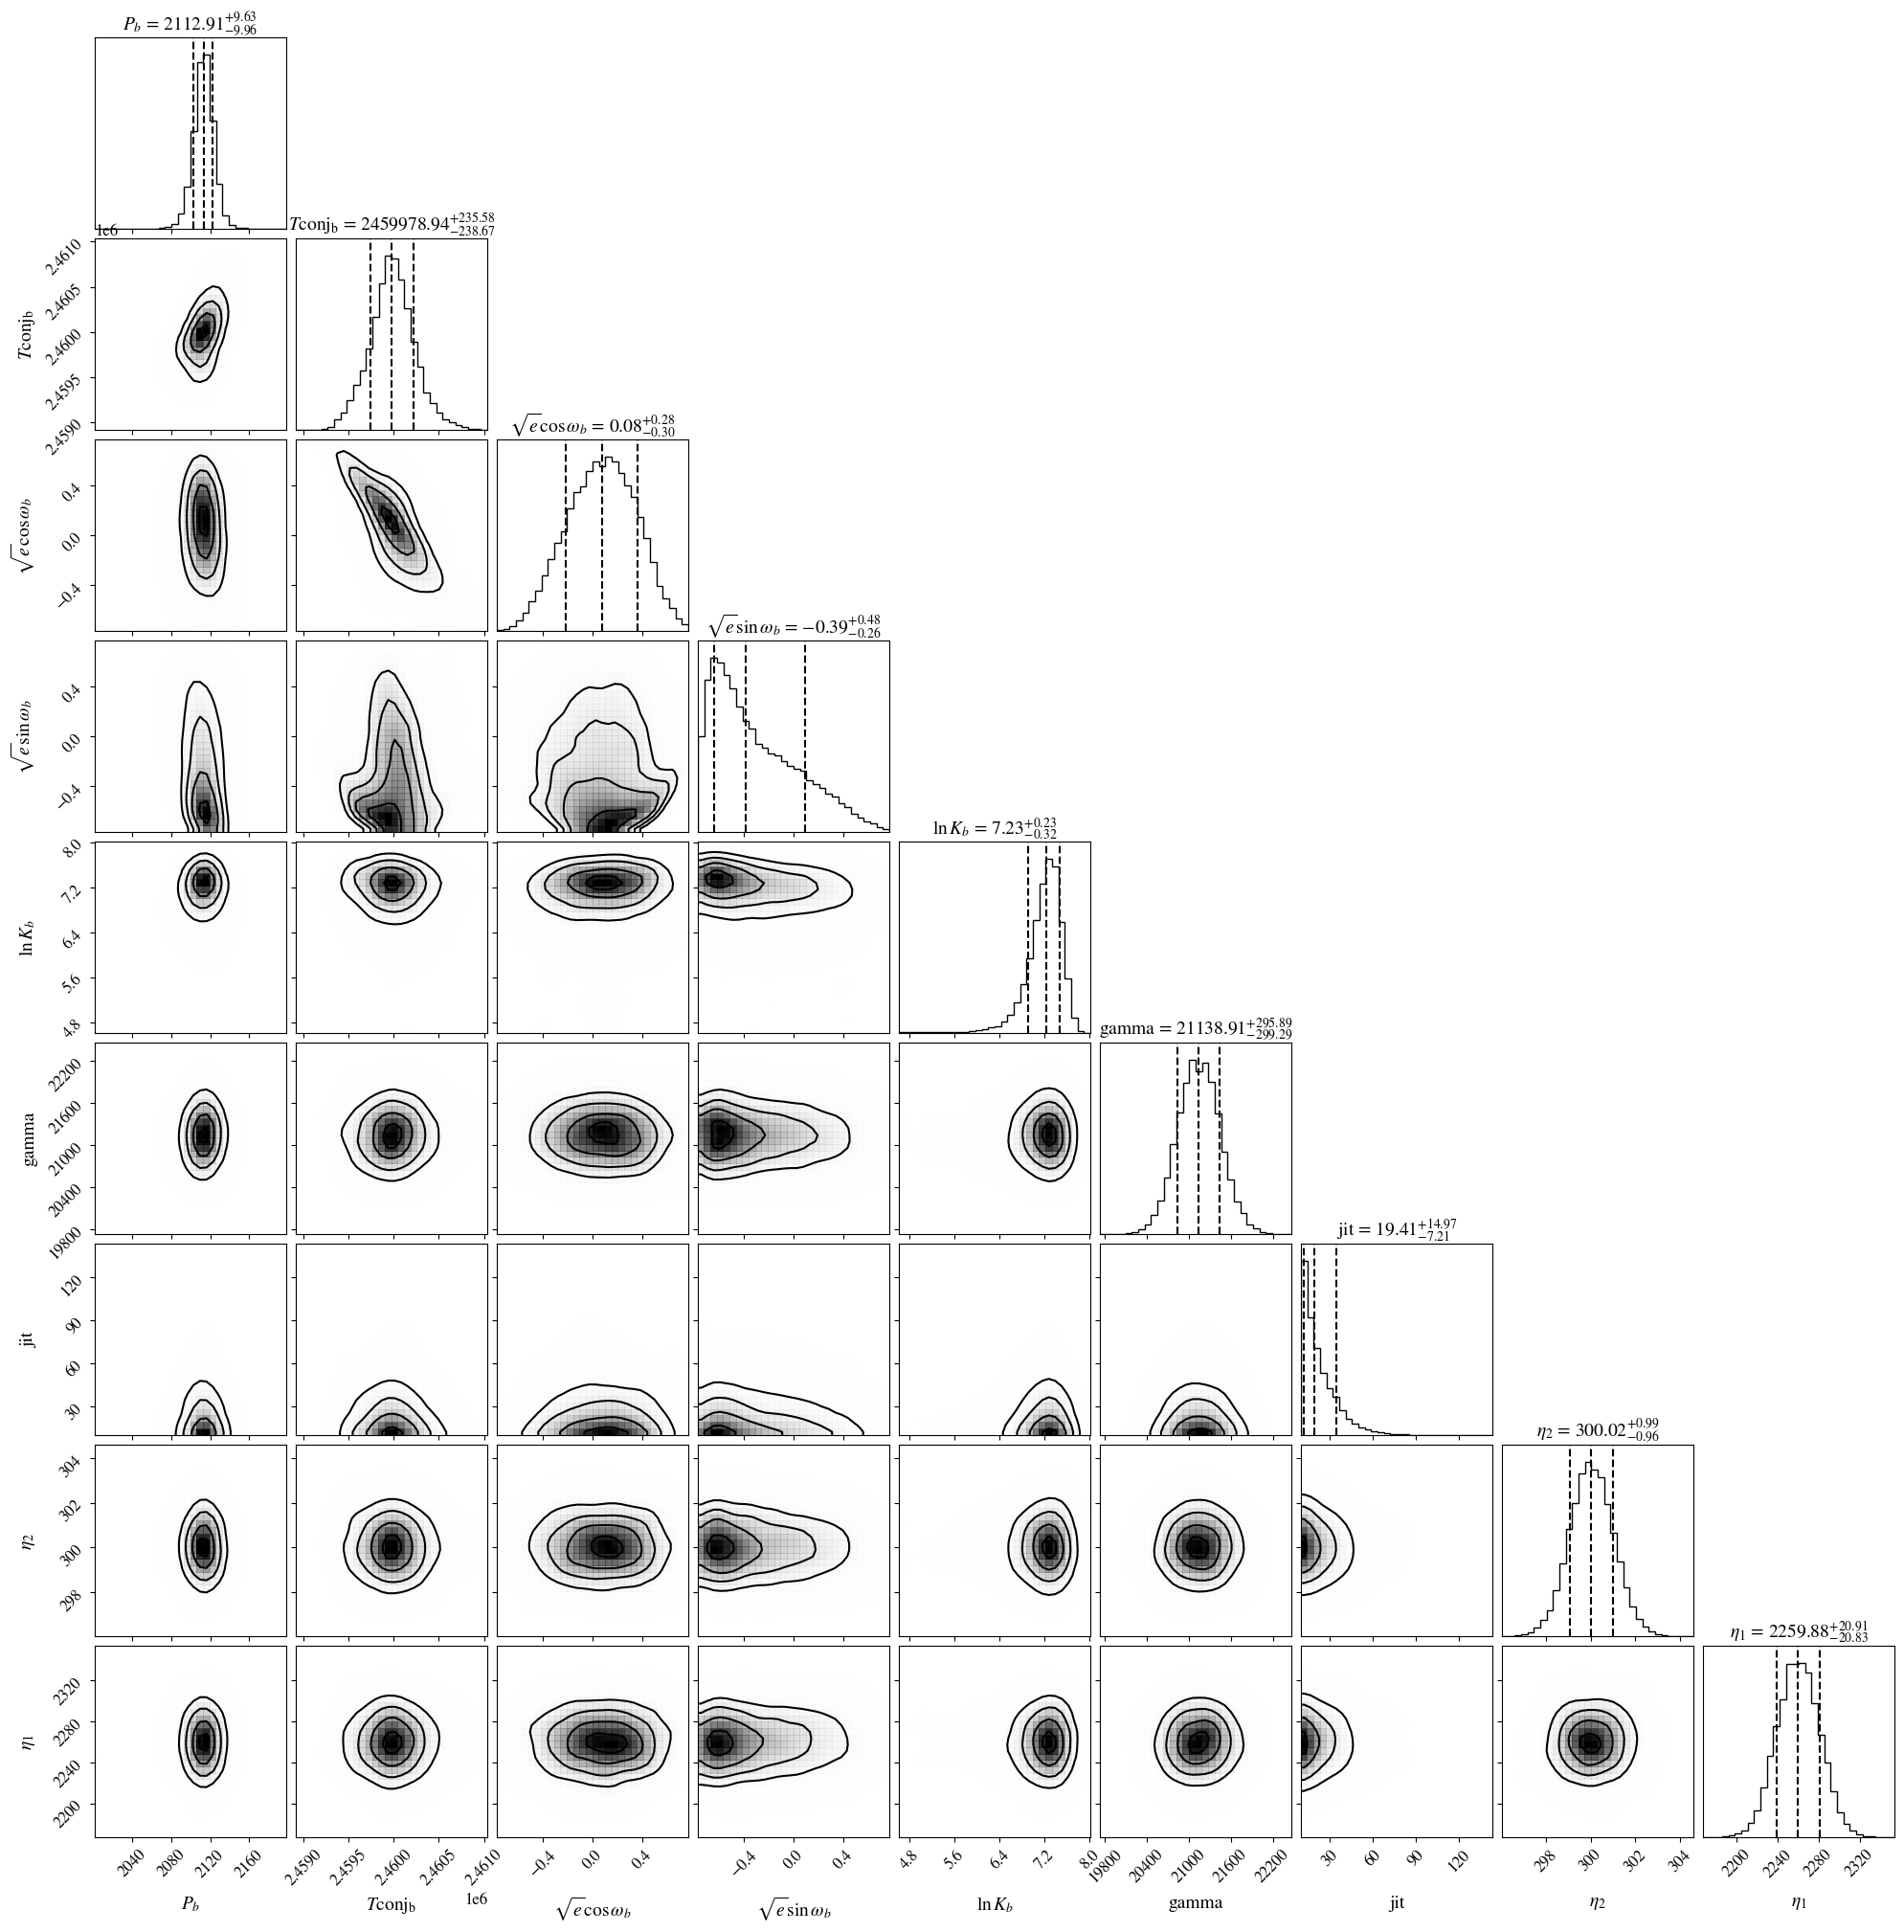

In [45]:
Corner = mcmc_plots.CornerPlot(gppost, gpchains)
Corner.saveplot = "figs/corner_mcmc_full.pdf"
Corner.plot()

In [70]:
df_synth = gppost.params.basis.to_synth(gpchains)
df_synth['tc1_year'] = Time(df_synth['tc1'],format='jd').jyear
labels = 'per1 tc1_year e1 k1 logk1 gamma'.split()
df_synth[labels].quantile([0.01,0.05,0.14,0.5,0.84,0.95,0.99]).T

,0.01,0.05,0.14,0.50,0.84,0.95,0.99
per1,2082.789608,2094.825502,2101.952448,2112.907616,2122.533864,2129.541899,2138.390643
tc1_year,2021.506129,2021.951501,2022.374847,2023.090870,2023.735849,2024.259001,2024.914098
e1,0.004343,0.023492,0.067979,0.278385,0.513354,0.573781,0.594610
k1,319.189404,721.665329,965.681856,1380.191976,1736.761690,1977.260067,2203.801646
logk1,5.765785,6.581561,6.872834,7.229978,7.459778,7.589467,7.697939
gamma,20442.217364,20648.360928,20814.292574,21138.906479,21434.800157,21639.149419,21849.890865


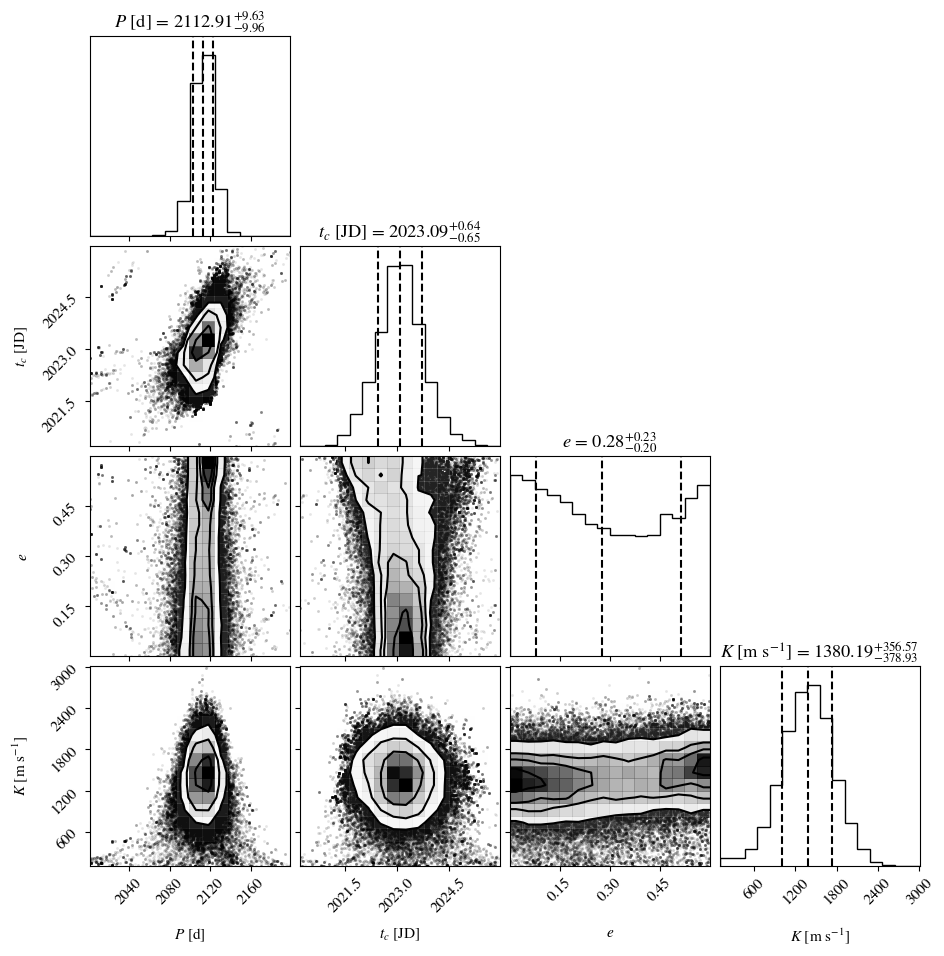

In [71]:
labels = 'per1 tc1_year e1 k1'.split()

fig = corner.corner(
    df_synth[labels],
    plot_datapoints=True,smooth=False,
    show_titles=True,bins=16,
    quantiles=[0.16,0.5,0.84],
    labels=["$P$ [d]", "$t_c$ [JD]","$e$","$K$ [m s$^{-1}$]"]
    )

fig.savefig("figs/corner_mcmc_synth.pdf",dpi=300)

In [82]:
def initialize_model_from_chain(ind,chain):
    if ind == -99:
        ind = random.randint(0,len(chain)-1)
    index_dict = chain.iloc[ind].to_dict()
    params = radvel.Parameters(1,basis='per tc secosw sesinw logk') 
    for pp in index_dict:
        params[pp] = radvel.Parameter(value=index_dict[pp],vary=False)
    mod = radvel.RVModel(params)
    return mod
    
    
def initialize_model_from_chain_circ(ind,chain):
    if ind == -99:
        ind = random.randint(0,len(chain)-1)
    index_dict = chain.iloc[ind].to_dict()
    params = radvel.Parameters(1,basis='per tc secosw sesinw logk') 
    print('Model index: ',index_dict)
    for pp in index_dict:
        params[pp] = radvel.Parameter(value=index_dict[pp],vary=False)
    params['secosw1'] = radvel.Parameter(value=0.0,vary=False)
    params['sesinw1'] = radvel.Parameter(value=0.0,vary=False)
    mod = radvel.RVModel(params)
    return mod


## NEAR-CIRCULAR SAMPLES, MEDIAN VALUES 
gpcirc = gpchains[df_synth['e1']<0.01]
#mymod = initialize_model_from_chain_circ(gpchains.lnprobability.argmax(),gpchains)
#for key in mymod.params.keys():
#    print("{:<13}".format(key),mymod.params[key])

mean_circ_params = radvel.Parameters(1,basis='per tc secosw sesinw logk')

mean_circ_params['per1'] = radvel.Parameter(value = gpcirc.quantile(0.5).per1)
mean_circ_params['tc1']  = radvel.Parameter(value = gpcirc.quantile(0.5).tc1 )
mean_circ_params['secosw1'] = radvel.Parameter(value = 0)
mean_circ_params['sesinw1'] = radvel.Parameter(value = 0)
mean_circ_params['logk1'] = radvel.Parameter(value=gpcirc.quantile(0.5).logk1)
mean_circ_params['gp_amp'] = radvel.Parameter(value=gpcirc.quantile(0.5).gp_amp)
mean_circ_params['gp_length'] = radvel.Parameter(value=gpcirc.quantile(0.5).gp_length)
mean_circ_params['jit'] = radvel.Parameter(value=gpcirc.quantile(0.5).jit)
mean_circ_params['gamma'] = radvel.Parameter(value=gpcirc.quantile(0.5).gamma)

mean_circ_params

print("mean tc1 = ",Time(2459999.132909865,format='jd').jyear)

# MODEL AND LIKE
mymod = radvel.RVModel(mean_circ_params)
for key in mymod.params.keys():
    print("{:<13}".format(key),mymod.params[key])
mylike = radvel.likelihood.GPLikelihood(mymod, gppost.likelihood.x, gppost.likelihood.y, gppost.likelihood.yerr,
                                    hnames=['gp_amp','gp_length'],kernel_name='Exp')

# ARRAYS
t = mylike.x
vel = mylike.y
errvel = mylike.yerr

gpmu,stddev = mylike.predict(t)

### GET FLATTENED ARRAYS
vel_flat = vel - gpmu - mylike.params['gamma'].value
errvel_flat = np.sqrt(errvel**2 + mylike.params['jit'].value**2 + stddev**2)
errvel_flat_nojit = np.sqrt(errvel**2 + stddev**2)

mean tc1 =  2023.1461544417937
per1          Parameter object: value = 2110.3967462690302, vary = True, mcmc scale = None
tc1           Parameter object: value = 2460006.2112176316, vary = True, mcmc scale = None
secosw1       Parameter object: value = 0, vary = True, mcmc scale = None
sesinw1       Parameter object: value = 0, vary = True, mcmc scale = None
logk1         Parameter object: value = 7.186209479262929, vary = True, mcmc scale = None
gp_amp        Parameter object: value = 2260.0007939667116, vary = True, mcmc scale = None
gp_length     Parameter object: value = 300.0083387241364, vary = True, mcmc scale = None
jit           Parameter object: value = 19.46140395410586, vary = True, mcmc scale = None
gamma         Parameter object: value = 21138.042473724636, vary = True, mcmc scale = None


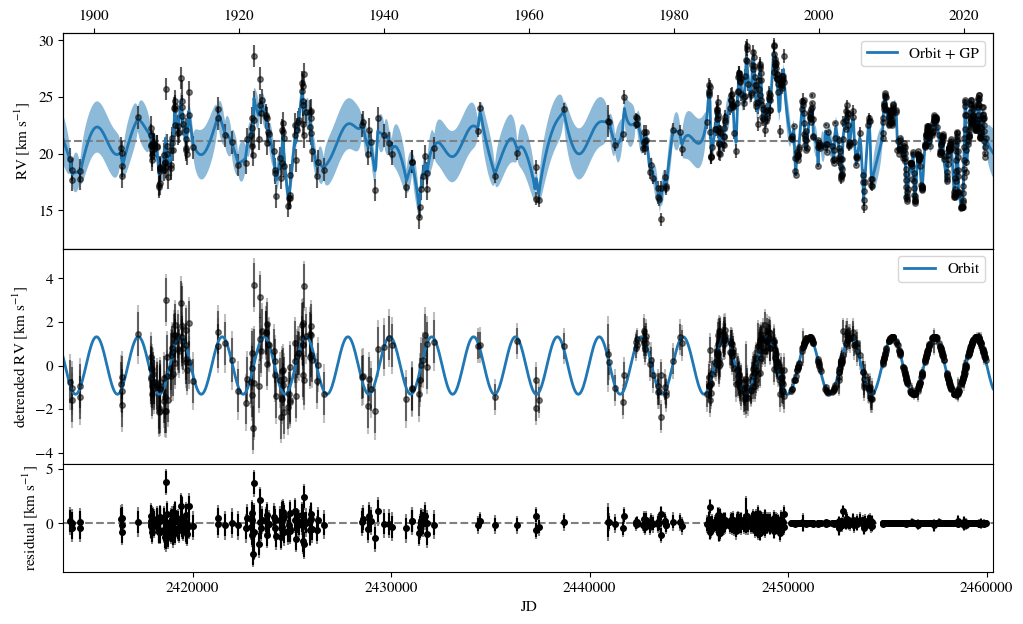

In [84]:
mean_jit = mylike.params['jit'].value #np.mean(gpcirc['jit'])
nlines = 1
yrange = 19

ms = 4


fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(12, 7),
                       gridspec_kw={'height_ratios': [2,2,1],'hspace': 0},sharex=True)




ti = np.linspace(mylike.x[0]-365,mylike.x[-1]+365,1000)
gpmu,stddev = mylike.predict(ti)



axs[0].set_ylabel('RV [km s$^{-1}$]')
axs[0].plot(ti,np.ones_like(ti)*mylike.params['gamma'].value/vfactor,ls='--',color='grey')
axs[0].errorbar(mylike.x,mylike.y/vfactor,np.sqrt(mylike.yerr**2 + mean_jit**2)/vfactor,marker='',
                linestyle='',color='grey',alpha=0.5)
axs[0].errorbar(mylike.x,mylike.y/vfactor,mylike.yerr/vfactor,marker='o',
                linestyle='',color='k',alpha=0.5,markersize=ms)


axs[0].fill_between(ti,
                    (mymod(ti)+gpmu + stddev + mymod.params['gamma'].value)/vfactor,
                    (mymod(ti)+gpmu - stddev + mymod.params['gamma'].value)/vfactor,color='C0',alpha=0.5,label='',edgecolor=None)
axs[0].plot(ti,(mymod(ti)+ gpmu + mymod.params['gamma'].value)/vfactor ,color='C0',alpha=1,lw=2,label='Orbit + GP')

axs[0].legend(loc=0)
axs[0].set_ylim(-yrange/2+mylike.params['gamma'].value/vfactor,
                 yrange/2+mylike.params['gamma'].value/vfactor)
axs[0].set_xlim(ti[0],ti[-1])
ayr = axs[0].twiny()
ayr.set_xlim(Time(ti[0],format='jd').jyear, Time(ti[-1],format='jd').jyear)


axs[1].set_ylabel('detrended RV [km s$^{-1}$]')
axs[1].errorbar(mylike.x,(mylike.y-mylike.predict(mylike.x)[0]-mylike.params['gamma'].value)/vfactor,
                np.sqrt(mylike.yerr**2 + mean_jit**2 + mylike.predict(mylike.x)[1]**2)/vfactor,marker='',linestyle='',color='grey',alpha=0.5)
axs[1].errorbar(mylike.x,(mylike.y-mylike.predict(mylike.x)[0]-mylike.params['gamma'].value)/vfactor,
                mylike.yerr/vfactor,marker='o',linestyle='',color='k',alpha=0.5,markersize=ms)
axs[1].plot(ti,mymod(ti)/vfactor ,color='C0',alpha=1,lw=2,label='Orbit')
axs[1].legend(loc=0)

axs[2].set_ylabel('residual [km s$^{-1}$]')
axs[2].plot(ti,np.zeros_like(ti),ls='--',color='grey')

axs[2].errorbar(mylike.x,(mylike.y-mylike.predict(mylike.x)[0]-mylike.params['gamma'].value-mylike.model(mylike.x))/vfactor,
                np.sqrt(mylike.yerr**2 + mean_jit**2 + mylike.predict(mylike.x)[1]**2)/vfactor,marker='',linestyle='',color='grey')
axs[2].errorbar(mylike.x,(mylike.y-mylike.predict(mylike.x)[0]-mylike.params['gamma'].value-mylike.model(mylike.x))/vfactor,
                mylike.yerr/vfactor,marker='o',linestyle='',color='k',markersize=ms)
#axs[1].set_ylim(-yrange/2,yrange/2)
axs[2].set_xticks([2420000,2430000,2440000,2450000,2460000])
axs[2].xaxis.set_major_formatter(ticker.FormatStrFormatter("%i"))
axs[2].set_xlabel('JD')

"""
mylw = 1
myalpha = 0.25
for i in range(nlines):
    mymod = initialize_model_from_chain(-99,gpcirc)
    mylike = radvel.likelihood.GPLikelihood(mymod, mylike.x, mylike.y, mylike.yerr,
                                        hnames=['gp_amp','gp_length'],kernel_name='SqExp')
    gpmu,stddev = mylike.predict(ti)
    
    axs[0].plot(ti,(gpmu + mymod.params['gamma'].value)/vfactor,color='C1',alpha=myalpha,lw=mylw)
    axs[0].plot(ti,(mymod(ti)+ gpmu + mymod.params['gamma'].value)/vfactor ,color='C0',alpha=myalpha,lw=mylw)
    
"""

plt.subplots_adjust(hspace=0)


#rva = Table.read('RVs/BG_rv10.csv')
#axs[0].errorbar(rva['JD'],rva['RV'],rva['RV_err'],color='r',marker='x',linestyle='')

fig.savefig("figs/RV_timeseries_model.pdf",bbox_inches='tight',dpi=300)